In [ ]:
import os
import re
import json
import faiss
import numpy as np
import huggingface_hub
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm import tqdm
from openai import OpenAI
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from langchain.schema import Document
from langchain_community.vectorstores.faiss import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore

from matplotlib import font_manager, rc
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

from dotenv import load_dotenv
load_dotenv("../keys.env")

openai_api_key = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key

hf_token = os.getenv("HF_TOKEN")
huggingface_hub.login(hf_token)

In [2]:
client = OpenAI()
model = "gpt-4o"

In [2]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def load_document(path='../dataset/documents.jsonl'):
    raw_documents = load_jsonl(path)

    documents = []
    for doc in raw_documents:
        doc_id = doc['docid']
        content = doc['content']
        documents.append(Document(page_content=content, metadata={"docid": doc_id}))

    return documents

documents = load_document(path="../dataset/processed_documents.jsonl")

In [4]:
def clean_json_response(response):
    # 코드 블록(예: ```json, ```) 제거
    cleaned_response = re.sub(r'```(?:json)?', '', response).strip()
    return cleaned_response

In [23]:
def generate_keyword(document, model:str, client:OpenAI):
    prompt = (
        "당신은 주어진 문서를 읽고 이해하여 핵심을 파악하는 언어 전문가입니다. "
        "주어진 문서를 읽은 후에 문서와 관련성이 높은 하나의 질문을 생성한 후, 해당 문서에서 핵심이 되는 키워드 하나를 생성합니다. "
        "추가적으로 해당 문서가 어떤 분야에 해당하는지도 하나의 단어로 생성해야 합니다. "
        "반환하는 형식은 반드시 JSON 포맷이어야 하며, 모든 문자열은 쌍따옴표로 감싸야 합니다. "
        "형식은 다음과 같아야 합니다: "
        '{ "question": "생성한 질문", "keyword": "생성한 키워드", "domain": "생성한 분야" }. '
        "예를 들어: "
        '{ "question": "새의 얇은 부리는 어떤 상황에서 유용한가?", "keyword": "얇은 부리", "domain": "동물학" }.'
    )

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role" : "system", "content" : prompt},
            {"role" : "user", "content" : document}
        ],
    )
    
    response = completion.choices[0].message.content
    response = clean_json_response(response)
    
    try:
        json_response = json.loads(response)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON response", "response": response}
    
    return json_response

In [ ]:
# sample_doc = documents[0]
# print(sample_doc.page_content)

# result = generate_keyword(sample_doc.page_content, model, client)
# print(result)

In [ ]:
# labeled_documents = []

# for idx, doc in enumerate(documents):
#     docid = doc.metadata.get('docid')
#     content = doc.page_content
#     print(f"{idx}\n{docid}\n{content}")

#     result = generate_keyword(content, model, client)
#     print(f"{result}\n") ## question, keyword
    
#     if "keyword" in result and 'question' in result and 'domain' in result:
#         doc.metadata["question"] = result["question"]
#         doc.metadata["domain"] = result["domain"]
#         doc.metadata["label"] = result["keyword"]
#     else:
#         doc.metadata['question'] = None
#         doc.metadata["domain"] = None
#         doc.metadata["label"] = None
    
#     labeled_documents.append({
#         "docid": doc.metadata["docid"],
#         "content": doc.page_content,
#         "domain" : doc.metadata['domain'],
#         "question" : doc.metadata['question'],
#         "label": doc.metadata["label"]
#     })

In [28]:
# with open("../dataset/labeled_documents.jsonl", 'w', encoding='utf-8') as f:
#     for entry in labeled_documents:
#         json.dump(entry, f, ensure_ascii=False)
#         f.write('\n')

In [13]:
def load_document(path="../dataset/labeled_documents.jsonl"):
    raw_documents = load_jsonl(path)

    documents = []
    for doc in raw_documents:
        doc_id = doc['docid']
        content = doc['content']
        domain = doc['domain']
        label = doc['label']
        question = doc['question']

        documents.append(Document(page_content=content, metadata={"docid": doc_id, "domain" : domain, "label" : label, "question" : question}))

    return documents

In [17]:
documents = load_document(path="../dataset/labeled_documents.jsonl")

model_name = "intfloat/multilingual-e5-large-instruct"
model_kwargs = {"device": "cuda:0"}
encode_kwargs = {"normalize_embeddings": False,
                    "clean_up_tokenization_spaces": True}

encoder = HuggingFaceEmbeddings(model_name=model_name,
                                model_kwargs=model_kwargs,
                                encode_kwargs=encode_kwargs)


def score_normalizer(val: float) -> float:
    return 1 / (1 + val)

index = faiss.IndexFlatL2(len(encoder.embed_query("파이썬")))

vector_store = FAISS(
    embedding_function=encoder,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
    relevance_score_fn=score_normalizer
)

vector_store.add_documents(documents=documents)
retrieval = vector_store

In [19]:
total_domains = set()
for doc in documents:
    total_domains.add(doc.metadata.get("domain"))

print(len(total_domains))

311


In [20]:
all_pages_content = [doc.page_content for doc in documents]
document_embeddings = encoder.embed_documents(all_pages_content)
document_embeddings = np.vstack(document_embeddings)

In [23]:
reduction_method = "t-SNE"  # PCA 또는 t-SNE 선택
if reduction_method == "PCA":
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(document_embeddings)

elif reduction_method == "t-SNE":
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(document_embeddings)

/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ff8c8f8cf70>
Traceback (most recent call last):
  File "/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/threadpoolctl.py", l

/tmp/ipykernel_649970/2350808056.py:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/tmp/ipykernel_649970/2350808056.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


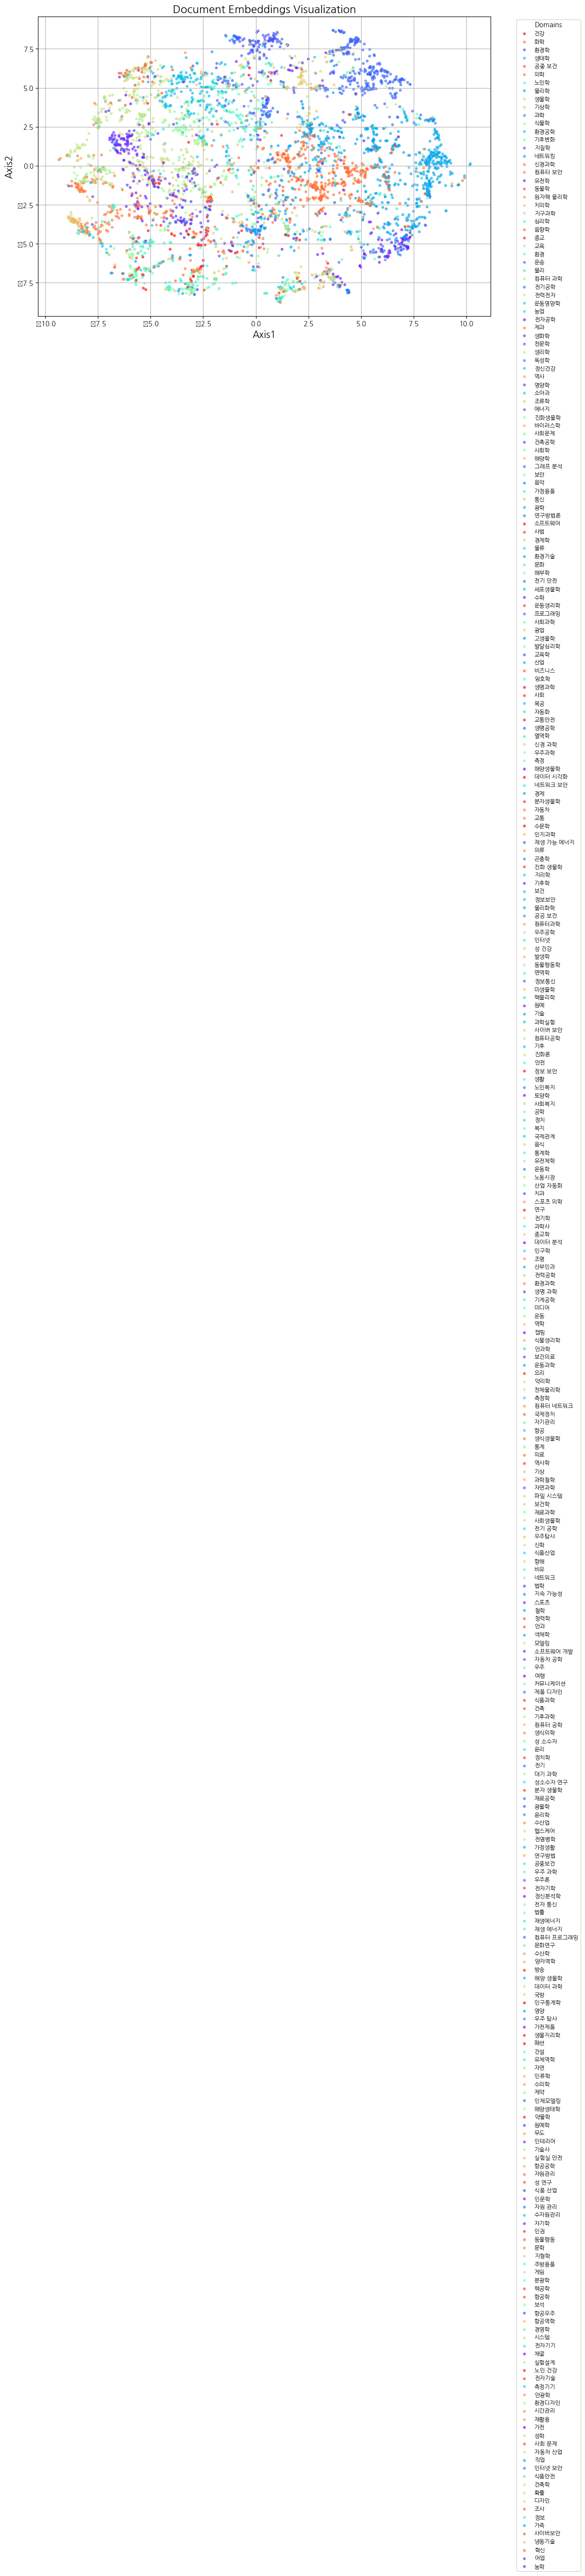

In [25]:
plt.figure(figsize=(12, 8))

domains = [doc.metadata.get("domain") for doc in documents]
unique_domains = list(set(domains))
if None in unique_domains:
    unique_domains.remove(None)

colors = cm.rainbow(np.linspace(0, 1, len(unique_domains)))
domain_to_color = {domain: color for domain, color in zip(unique_domains, colors)}

added_domains = set()
for i, doc in enumerate(documents):
    domain = doc.metadata.get("domain")
    if domain is None:
        continue
    color = domain_to_color.get(domain)

    if domain not in added_domains:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=color, label=domain, alpha=0.6, s=10)
        added_domains.add(domain)
    else:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=color, alpha=0.6, s=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Domains", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title('Document Embeddings Visualization', fontsize=16)
plt.xlabel('Axis1', fontsize=14)
plt.ylabel('Axis2', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()